Index(['intelligence_category', 'sensitivity_level', 'tolerates_being_alone',
       'kid_friendly', 'dog_friendly', 'stranger_friendly',
       'potential_for_mouthiness', 'prey_drive', 'tendency_to_bark_or_howl',
       'wanderlust_potential', 'exercise_needs', 'energy_level',
       'severity_score', 'yearly_final_cost'],
      dtype='object')
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 152400, number of used features: 10
[LightGBM] [Info] Start training from score -2.440249
[LightGBM] [Info] Start training from score -2.472465
[LightGBM] [Info] Start training from score -0.188157


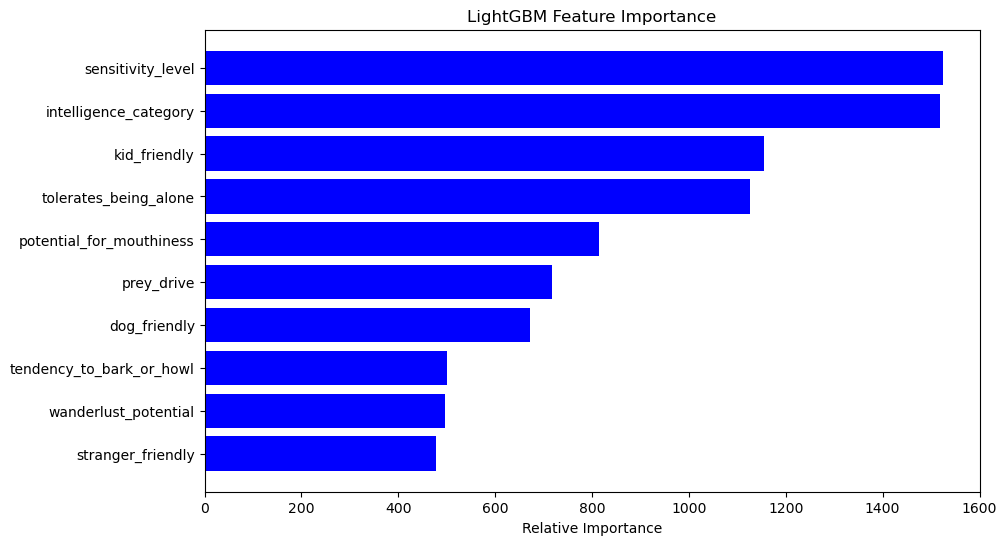

--------------------------------------------------------------------
BEHAVIOUR DATASET
Accuracy Score: 0.9998162729658793
Classification Report:
               precision    recall  f1-score   support

           2       1.00      1.00      1.00      3366
           3       1.00      1.00      1.00      3275
           4       1.00      1.00      1.00     31459

    accuracy                           1.00     38100
   macro avg       1.00      1.00      1.00     38100
weighted avg       1.00      1.00      1.00     38100

Confusion Matrix:
 [[ 3360     6     0]
 [    0  3274     1]
 [    0     0 31459]]
Model Accuracy: 99.98%


In [60]:

# Import the necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import lightgbm as lgb

# Load the CSV files
df = pd.read_csv('nobreed_data.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0).astype(int)

# ------------ BEHAVIOUR TESTING ----------------

# Drop unnecessary columns in df_breed
behaviour = df.drop(columns=['longevity','size', 'gender', 'age','grooming_required','tolerates_hot_weather', 'tolerates_cold_weather',
                             'category_companion', 'category_herding', 'category_hound',
                               'category_sporting', 'category_terrier', 'category_working',
                             'allergies', 'bleeding', 'bloat','breathing', 'cleft_palate', 'dental', 'elbows', 'eyes', 'heart',
                           'hips', 'kidney', 'liver', 'metabolic', 'neurological', 'none',
                           'osteopathy', 'patella', 'respiratory', 'skin', 'spine', 'thyroid',
                           'urinary'], axis=1)

print(behaviour.columns)

# Split the dataset into variables and target feature
X = behaviour.drop('yearly_final_cost', axis=1)
y = behaviour['yearly_final_cost']

# Define bins and labels for binning the target feature
bins = [2025, 2500, 2900, 3300, 3580, np.inf]
labels = ['lowest', 'low', 'medium', 'high', 'highest']
y_binned = pd.cut(y, bins=bins, labels=labels)

# Encode the labels into numerical values
y_encoded = y_binned.cat.codes

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=123)

# Apply light gradient machine boosting, to analyze feature importance.
lightgbm_model = lgb.LGBMClassifier(n_estimators=100, random_state=123)
lightgbm_model.fit(X_train, y_train)

def plot_feature_importances(importances, feature_names, title):
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_feature_importances(lightgbm_model.feature_importances_, X.columns, 'LightGBM Feature Importance')

# Train the model
knn = KNeighborsClassifier(n_neighbors=7, metric='minkowski')
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Model evaluation
print("--------------------------------------------------------------------")
print("BEHAVIOUR DATASET")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

